In [1]:
# pip install medmnist

# IMA206-projet

## Self-supervised learning for medical image classification

## Part for SimCLR

Ref: github of SimCLR: https://github.com/google-research/simclr

In [2]:
import medmnist
from medmnist import INFO
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split



# Load the dataset
data_flag = 'pathmnist'
download = True

# Get dataset information
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# Define transformations for data augmentation
data_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=64, scale=(0.2, 1.0)),  # random resized crop
    transforms.RandomHorizontalFlip(p=0.5),  # random horizontal flip
    # transforms.RandomApply([transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1)], p=0.8),  # color blurring
    transforms.RandomGrayscale(p=0.2),  # random gray
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=23)], p=0.5),  # random gaussian blur
    transforms.RandomRotation(degrees=15),  # random rotate
    transforms.ToTensor(),  # to tensor
    transforms.Normalize(mean=[.5], std=[.5]) # normalize
])

org_data_transform = transforms.Compose([
    transforms.ToTensor(),  # to tensor
    transforms.Normalize(mean=[.5], std=[.5]) # normalize
])

org_train_dataset = DataClass(split='train', transform= org_data_transform , download=download)
aug_train_dataset = DataClass(split='train', transform=data_transform, download=download)

# # Load the dataset
# train_dataset = DataClass(split='train', transform=data_transform, download=download)
# train_loader = DataLoader(dataset=train_dataset, batch_size=256, shuffle=True, num_workers=4, pin_memory=True)

# val_dataset = DataClass(split='val', transform=data_transform, download=download)
# val_loader = DataLoader(dataset=val_dataset, batch_size=256, shuffle=False, num_workers=4, pin_memory=True)


In [3]:
org_train_dataset = DataClass(split='train', transform= org_data_transform , download=download)
aug_train_dataset = DataClass(split='train', transform=data_transform, download=download)

Using downloaded and verified file: /home/ubuntu/.medmnist/pathmnist.npz
Using downloaded and verified file: /home/ubuntu/.medmnist/pathmnist.npz


In [7]:
from torch.utils.data import Dataset

class PairedDataset(Dataset):
    def __init__(self, org_dataset, aug_dataset):
        self.org_dataset = org_dataset
        self.aug_dataset = aug_dataset
        assert len(org_dataset) == len(aug_dataset), "Datasets must be of the same length"

    def __len__(self):
        return len(self.org_dataset)

    def __getitem__(self, idx):
        org_image, _ = self.org_dataset[idx]
        aug_image, _ = self.aug_dataset[idx]
        return org_image, aug_image


paired_dataset = PairedDataset(org_train_dataset, aug_train_dataset)
train_loader = DataLoader(paired_dataset, batch_size=256, shuffle=True, num_workers=4, pin_memory=True)




In [8]:

org_val_dataset = DataClass(split='val', transform=org_data_transform, download=download)
aug_val_dataset = DataClass(split='val', transform=data_transform, download=download)

val_paired_dataset = PairedDataset(org_val_dataset, aug_val_dataset)

# val_loader = DataLoader(dataset=val_paired_dataset, batch_size=256, shuffle=False, num_workers=4, pin_memory=True)

Using downloaded and verified file: /home/ubuntu/.medmnist/pathmnist.npz
Using downloaded and verified file: /home/ubuntu/.medmnist/pathmnist.npz


In [9]:
# Define the SimCLR model
class SimCLR(nn.Module):
    def __init__(self, base_model, out_dim):
        super(SimCLR, self).__init__()
        self.encoder = self.get_resnet(base_model)
        self.projector = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, out_dim)
        )

    def get_resnet(self, base_model):
        model = models.__dict__[base_model](pretrained=False)
        model = nn.Sequential(*list(model.children())[:-1])
        return model

    def forward(self, x):
        h = self.encoder(x)
        h = h.squeeze()
        z = self.projector(h)
        return h, z

model = SimCLR(base_model='resnet18', out_dim=128).cuda()   # output dimension = 128

# Define the NT-Xent Loss function
class NT_XentLoss(nn.Module):
    def __init__(self, temperature):
        super(NT_XentLoss, self).__init__()
        self.temperature = temperature
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

    def mask_correlated_samples(self, batch_size):
        N = 2 * batch_size
        mask = torch.ones((N, N), dtype=bool)
        mask = mask.fill_diagonal_(0)
        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0
        return mask

    def forward(self, z_i, z_j):
        batch_size = z_i.size(0)
        N = 2 * batch_size
        z = torch.cat((z_i, z_j), dim=0)
        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature

        mask = self.mask_correlated_samples(batch_size)

        sim_i_j = torch.diag(sim, batch_size)
        sim_j_i = torch.diag(sim, -batch_size)

        positives = torch.cat([sim_i_j, sim_j_i], dim=0)
        negatives = sim[mask].reshape(N, -1)

        labels = torch.zeros(N).to(positives.device).long()
        logits = torch.cat((positives.unsqueeze(1), negatives), dim=1)
        loss = self.criterion(logits, labels)
        # print(labels)
        return loss / N

criterion = NT_XentLoss(temperature=0.5).cuda()   # temperature

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-6)

/mnt/data/anaconda3/envs/pytorch_1_12/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/data/anaconda3/envs/pytorch_1_12/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [22]:
num_epochs = 10

def train(model, train_loader, criterion, optimizer, epoch):
    model.train()
    total_loss = 0
    for batch_idx, (org_images,aug_images) in enumerate(train_loader):
            org_images = org_images.cuda()
            aug_images = aug_images.cuda()
            
            z_i = model(org_images)
            z_j = model(aug_images)
            
            if isinstance(z_i, tuple):
                z_i = z_i[0]
            if isinstance(z_j, tuple):
                z_j = z_j[0]
            
            loss = criterion(z_i, z_j)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            if batch_idx % 10 == 0:
                print(f'Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item()}')
    return total_loss / len(train_loader)



In [29]:
val_loader = DataLoader(dataset=org_val_dataset, batch_size=256, shuffle=False, num_workers=4, pin_memory=True)


In [23]:
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, epoch)
    print(f'Epoch {epoch}, Train Loss: {train_loss}')

# Save features for evaluation
def save_features(model, data_loader, filename):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for data, target in data_loader:
            data = data.cuda()
            h, _ = model(data)
            features.append(h.cpu().numpy())
            labels.append(target.numpy())
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    np.savez(filename, features=features, labels=labels)

save_features(model, val_loader, 'pathmnist_features.npz')

Epoch 0, Batch 0, Loss: 4.68334436416626
Epoch 0, Batch 10, Loss: 4.7260637283325195
Epoch 0, Batch 20, Loss: 4.676408290863037
Epoch 0, Batch 30, Loss: 4.669305324554443
Epoch 0, Batch 40, Loss: 4.685487747192383
Epoch 0, Batch 50, Loss: 4.659368515014648
Epoch 0, Batch 60, Loss: 4.694771766662598
Epoch 0, Batch 70, Loss: 4.661527633666992
Epoch 0, Batch 80, Loss: 4.639388561248779
Epoch 0, Batch 90, Loss: 4.646059036254883
Epoch 0, Batch 100, Loss: 4.682951927185059
Epoch 0, Batch 110, Loss: 4.667937755584717
Epoch 0, Batch 120, Loss: 4.681015968322754
Epoch 0, Batch 130, Loss: 4.654914855957031
Epoch 0, Batch 140, Loss: 4.685214042663574
Epoch 0, Batch 150, Loss: 4.665207386016846
Epoch 0, Batch 160, Loss: 4.659677505493164
Epoch 0, Batch 170, Loss: 4.6758527755737305
Epoch 0, Batch 180, Loss: 4.645818710327148
Epoch 0, Batch 190, Loss: 4.635185718536377
Epoch 0, Batch 200, Loss: 4.665109634399414
Epoch 0, Batch 210, Loss: 4.647837162017822
Epoch 0, Batch 220, Loss: 4.66251325607299

In [30]:
save_features(model, val_loader, 'pathmnist_features.npz')

In [31]:
# Load features
data = np.load('pathmnist_features.npz')
features = data['features']
labels = data['labels']


print(features_2d.shape)  # 应该是 (num_samples, 2)
print(labels.shape)  

(10004, 2)
(10004, 1)


In [28]:
# for key in data.keys():
#     print(f"Key: {key}")
#     print(f"Shape: {data[key].shape}")
#     print(f"Data type: {data[key].dtype}")

Key: features
Shape: (10004, 512)
Data type: float32
Key: labels
Shape: (10004, 3, 64, 64)
Data type: float32


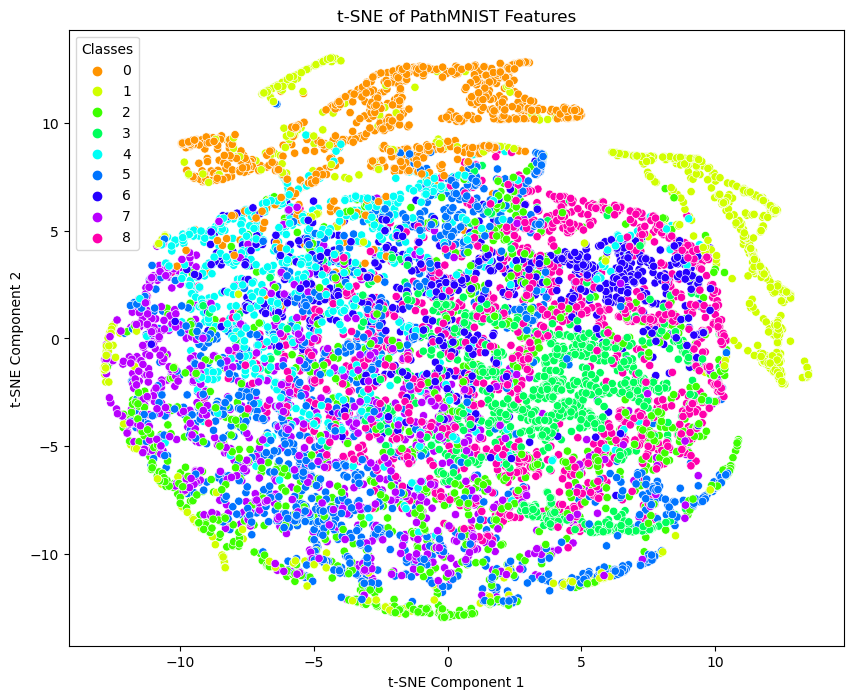

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd

# Load features
data = np.load('pathmnist_features.npz')
features = data['features']
labels = data['labels']

# Perform t-SNE to reduce dimensions to 2
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
features_2d = tsne.fit_transform(features)

# Ensure labels are 1D
labels = labels.squeeze()

# Create a DataFrame with the t-SNE results and labels
df = pd.DataFrame({
    'TSNE1': features_2d[:, 0],
    'TSNE2': features_2d[:, 1],
    'Label': labels
})

# Visualize the 2D features
plt.figure(figsize=(10, 8))
palette = sns.color_palette("hsv", len(set(labels)))
sns.scatterplot(data=df, x='TSNE1', y='TSNE2', hue='Label', legend='full', palette=palette)
plt.title('t-SNE of PathMNIST Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Classes')
plt.show()


### Validation:

In [33]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load features
data = np.load('pathmnist_features.npz')
features = data['features']
labels = data['labels']

# Split data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Train logistic regression classifier
classifier = LogisticRegression(max_iter=1000, random_state=42)
classifier.fit(X_train, y_train)

# Predict on validation set
y_pred = classifier.predict(X_val)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f'Validation Accuracy: {accuracy:.4f}')

# Save the model parameters
torch.save(model.state_dict(), 'simclr_model.pth')

/mnt/data/anaconda3/envs/pytorch_1_12/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Validation Accuracy: 0.7231


/mnt/data/anaconda3/envs/pytorch_1_12/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Fine-Tuning:

#### We use 1% of the training data for fine-tuning

In [36]:
model = SimCLR(base_model='resnet18', out_dim=128).cuda()

# Load the saved model parameters
model.load_state_dict(torch.load('simclr_model.pth'))
model.eval()  # Set the model to evaluation mode


# Extract 1% of training data for fine-tuning
num_samples = len(org_train_dataset)
indices = list(range(num_samples))
np.random.shuffle(indices)
fine_tune_size = int(num_samples * 0.01)
fine_tune_indices = indices[:fine_tune_size]

fine_tune_sampler = torch.utils.data.SubsetRandomSampler(fine_tune_indices)
fine_tune_loader = DataLoader(dataset=org_train_dataset, batch_size=256, sampler=fine_tune_sampler)

# Define a simple classifier for fine-tuning
class FineTuneModel(nn.Module):
    def __init__(self, base_model, num_classes):
        super(FineTuneModel, self).__init__()
        self.encoder = base_model.encoder
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        h = self.encoder(x).squeeze()
        logits = self.classifier(h)
        return logits
# Convert numpy array to list for getting unique labels
num_classes = 9  #len(set(train_dataset.labels.tolist()))
fine_tune_model = FineTuneModel(model, num_classes).cuda()

# Define the loss function and optimizer for fine-tuning
criterion_fine_tune = nn.CrossEntropyLoss()
optimizer_fine_tune = optim.Adam(fine_tune_model.parameters(), lr=1e-4, weight_decay=1e-6)
# Fine-tuning loop
def fine_tune(model, fine_tune_loader, criterion, optimizer, epoch):
    model.train()
    total_loss = 0
    for batch_idx, (data, target) in enumerate(fine_tune_loader):
        data, target = data.cuda(), target.squeeze().long().cuda()  # Ensure target is 1D
        optimizer.zero_grad()

        # Forward pass
        logits = model(data)
        loss = criterion(logits, target)

        # Backward pass
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        if batch_idx % 10 == 0:
            print(f'Fine-tune Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item()}')
    return total_loss / len(fine_tune_loader)

# Fine-tune the model
fine_tune_epochs = 50
for epoch in range(fine_tune_epochs):
    fine_tune_loss = fine_tune(fine_tune_model, fine_tune_loader, criterion_fine_tune, optimizer_fine_tune, epoch)
    print(f'Fine-tune Epoch {epoch}, Train Loss: {fine_tune_loss}')



Fine-tune Epoch 0, Batch 0, Loss: 2.279015064239502
Fine-tune Epoch 0, Train Loss: 2.245935797691345
Fine-tune Epoch 1, Batch 0, Loss: 2.1542553901672363
Fine-tune Epoch 1, Train Loss: 2.124902129173279
Fine-tune Epoch 2, Batch 0, Loss: 2.02988600730896
Fine-tune Epoch 2, Train Loss: 2.010653555393219
Fine-tune Epoch 3, Batch 0, Loss: 1.9026962518692017
Fine-tune Epoch 3, Train Loss: 1.8856821060180664
Fine-tune Epoch 4, Batch 0, Loss: 1.8185145854949951
Fine-tune Epoch 4, Train Loss: 1.769435077905655
Fine-tune Epoch 5, Batch 0, Loss: 1.6809346675872803
Fine-tune Epoch 5, Train Loss: 1.6309804320335388
Fine-tune Epoch 6, Batch 0, Loss: 1.551655888557434
Fine-tune Epoch 6, Train Loss: 1.4911293685436249
Fine-tune Epoch 7, Batch 0, Loss: 1.3873769044876099
Fine-tune Epoch 7, Train Loss: 1.347233235836029
Fine-tune Epoch 8, Batch 0, Loss: 1.2695086002349854
Fine-tune Epoch 8, Train Loss: 1.2237818539142609
Fine-tune Epoch 9, Batch 0, Loss: 1.142884612083435
Fine-tune Epoch 9, Train Loss:

- Validation and see the accuracy result:

In [37]:
def save_features(model, data_loader, filename):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for data, target in data_loader:
            data = data.cuda()
            h = model(data)  # Only get the output from the classifier
            features.append(h.cpu().numpy())
            labels.append(target.numpy())
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    np.savez(filename, features=features, labels=labels)

# Save features from the fine-tuned model for evaluation
save_features(fine_tune_model, val_loader, 'pathmnist_features_fine_tuned.npz')

# Load features
data_fine_tuned = np.load('pathmnist_features_fine_tuned.npz')
features_fine_tuned = data_fine_tuned['features']
labels_fine_tuned = data_fine_tuned['labels']

# Split data into training and testing sets
X_train_fine_tuned, X_val_fine_tuned, y_train_fine_tuned, y_val_fine_tuned = train_test_split(features_fine_tuned, labels_fine_tuned, test_size=0.2, random_state=42)

# Standardize the features
scaler_fine_tuned = StandardScaler()
X_train_fine_tuned = scaler_fine_tuned.fit_transform(X_train_fine_tuned)
X_val_fine_tuned = scaler_fine_tuned.transform(X_val_fine_tuned)

# Train logistic regression classifier
classifier_fine_tuned = LogisticRegression(max_iter=1000, random_state=42)
classifier_fine_tuned.fit(X_train_fine_tuned, y_train_fine_tuned)

# Predict on validation set
y_pred_fine_tuned = classifier_fine_tuned.predict(X_val_fine_tuned)

# Calculate accuracy
accuracy_fine_tuned = accuracy_score(y_val_fine_tuned, y_pred_fine_tuned)
print(f'Fine-tuned Validation Accuracy: {accuracy_fine_tuned:.4f}')

/mnt/data/anaconda3/envs/pytorch_1_12/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fine-tuned Validation Accuracy: 0.7436


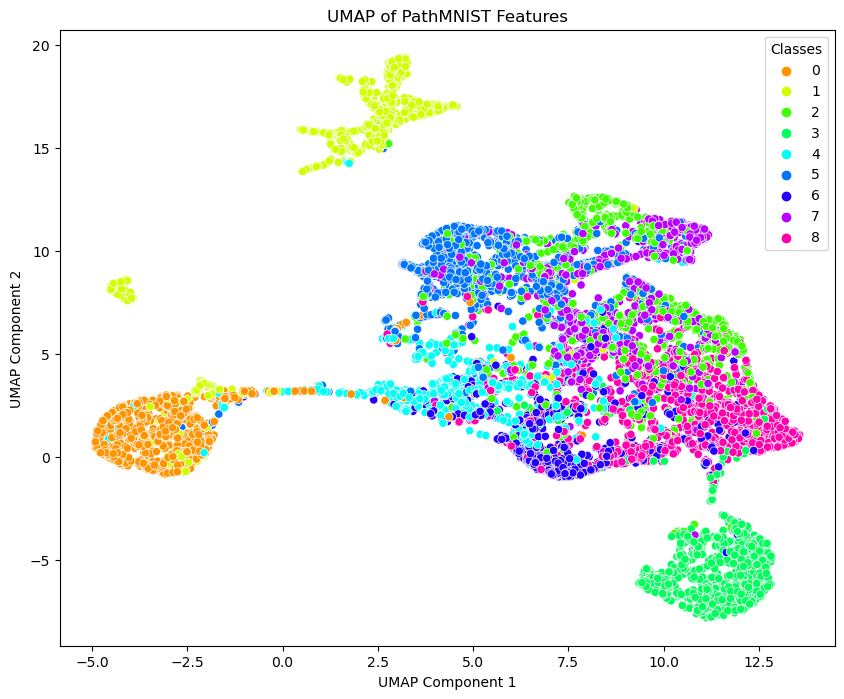

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import umap.umap_ as umap

data = np.load('pathmnist_features_fine_tuned.npz')
features = data['features']
labels = data['labels']

umap_reducer = umap.UMAP(n_components=2)
features_2d = umap_reducer.fit_transform(features)

# make sure labels are 1D
labels = labels.squeeze()

df = pd.DataFrame({
    'UMAP1': features_2d[:, 0],
    'UMAP2': features_2d[:, 1],
    'Label': labels
})

# visualize the 2D features
plt.figure(figsize=(10, 8))
palette = sns.color_palette("hsv", len(set(labels)))
sns.scatterplot(data=df, x='UMAP1', y='UMAP2', hue='Label', legend='full', palette=palette)
plt.title('UMAP of PathMNIST Features')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Classes')
plt.show()


#### We use 10% of the training data for fine-tuning

In [43]:
model = SimCLR(base_model='resnet18', out_dim=128).cuda()

# Load the saved model parameters
model.load_state_dict(torch.load('simclr_model.pth'))
model.eval()  # Set the model to evaluation mode


# Extract 10% of training data for fine-tuning
num_samples = len(org_train_dataset)
indices = list(range(num_samples))
np.random.shuffle(indices)
fine_tune_size = int(num_samples * 0.1)
fine_tune_indices = indices[:fine_tune_size]

fine_tune_sampler = torch.utils.data.SubsetRandomSampler(fine_tune_indices)
fine_tune_loader = DataLoader(dataset=org_train_dataset, batch_size=256, sampler=fine_tune_sampler)

# Define a simple classifier for fine-tuning
class FineTuneModel(nn.Module):
    def __init__(self, base_model, num_classes):
        super(FineTuneModel, self).__init__()
        self.encoder = base_model.encoder
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        h = self.encoder(x).squeeze()
        logits = self.classifier(h)
        return logits
# Convert numpy array to list for getting unique labels
num_classes = 9  #len(set(train_dataset.labels.tolist()))
fine_tune_model = FineTuneModel(model, num_classes).cuda()

# Define the loss function and optimizer for fine-tuning
criterion_fine_tune = nn.CrossEntropyLoss()
optimizer_fine_tune = optim.Adam(fine_tune_model.parameters(), lr=1e-4, weight_decay=1e-6)
# Fine-tuning loop
def fine_tune(model, fine_tune_loader, criterion, optimizer, epoch):
    model.train()
    total_loss = 0
    for batch_idx, (data, target) in enumerate(fine_tune_loader):
        data, target = data.cuda(), target.squeeze().long().cuda()  # Ensure target is 1D
        optimizer.zero_grad()

        # Forward pass
        logits = model(data)
        loss = criterion(logits, target)

        # Backward pass
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        if batch_idx % 10 == 0:
            print(f'Fine-tune Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item()}')
    return total_loss / len(fine_tune_loader)

# Fine-tune the model
fine_tune_epochs = 50
for epoch in range(fine_tune_epochs):
    fine_tune_loss = fine_tune(fine_tune_model, fine_tune_loader, criterion_fine_tune, optimizer_fine_tune, epoch)
    print(f'Fine-tune Epoch {epoch}, Train Loss: {fine_tune_loss}')



/mnt/data/anaconda3/envs/pytorch_1_12/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/data/anaconda3/envs/pytorch_1_12/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Fine-tune Epoch 0, Batch 0, Loss: 2.391105890274048
Fine-tune Epoch 0, Batch 10, Loss: 2.1155312061309814
Fine-tune Epoch 0, Batch 20, Loss: 1.8097904920578003
Fine-tune Epoch 0, Batch 30, Loss: 1.4585541486740112
Fine-tune Epoch 0, Train Loss: 1.8797903623845842
Fine-tune Epoch 1, Batch 0, Loss: 1.2914233207702637
Fine-tune Epoch 1, Batch 10, Loss: 1.0172964334487915
Fine-tune Epoch 1, Batch 20, Loss: 0.8526159524917603
Fine-tune Epoch 1, Batch 30, Loss: 0.8736678957939148
Fine-tune Epoch 1, Train Loss: 0.9888584067424139
Fine-tune Epoch 2, Batch 0, Loss: 0.7844290137290955
Fine-tune Epoch 2, Batch 10, Loss: 0.8342565298080444
Fine-tune Epoch 2, Batch 20, Loss: 0.6675941348075867
Fine-tune Epoch 2, Batch 30, Loss: 0.6599181294441223
Fine-tune Epoch 2, Train Loss: 0.718456443813112
Fine-tune Epoch 3, Batch 0, Loss: 0.7491931319236755
Fine-tune Epoch 3, Batch 10, Loss: 0.5668916702270508
Fine-tune Epoch 3, Batch 20, Loss: 0.640936553478241
Fine-tune Epoch 3, Batch 30, Loss: 0.6220696568

In [44]:
def save_features(model, data_loader, filename):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for data, target in data_loader:
            data = data.cuda()
            h = model(data)  # Only get the output from the classifier
            features.append(h.cpu().numpy())
            labels.append(target.numpy())
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    np.savez(filename, features=features, labels=labels)

# Save features from the fine-tuned model for evaluation
save_features(fine_tune_model, val_loader, 'pathmnist_features_fine_tuned.npz')

# Load features
data_fine_tuned = np.load('pathmnist_features_fine_tuned.npz')
features_fine_tuned = data_fine_tuned['features']
labels_fine_tuned = data_fine_tuned['labels']

# Split data into training and testing sets
X_train_fine_tuned, X_val_fine_tuned, y_train_fine_tuned, y_val_fine_tuned = train_test_split(features_fine_tuned, labels_fine_tuned, test_size=0.2, random_state=42)

# Standardize the features
scaler_fine_tuned = StandardScaler()
X_train_fine_tuned = scaler_fine_tuned.fit_transform(X_train_fine_tuned)
X_val_fine_tuned = scaler_fine_tuned.transform(X_val_fine_tuned)

# Train logistic regression classifier
classifier_fine_tuned = LogisticRegression(max_iter=1000, random_state=42)
classifier_fine_tuned.fit(X_train_fine_tuned, y_train_fine_tuned)

# Predict on validation set
y_pred_fine_tuned = classifier_fine_tuned.predict(X_val_fine_tuned)

# Calculate accuracy
accuracy_fine_tuned = accuracy_score(y_val_fine_tuned, y_pred_fine_tuned)
print(f'Fine-tuned Validation Accuracy: {accuracy_fine_tuned:.4f}')

/mnt/data/anaconda3/envs/pytorch_1_12/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fine-tuned Validation Accuracy: 0.8366


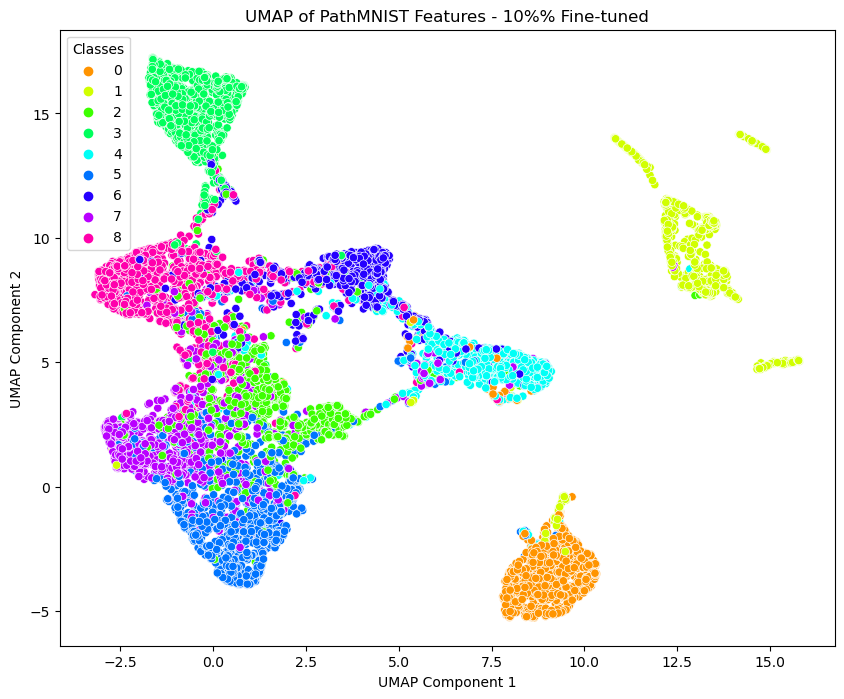

In [47]:
data = np.load('pathmnist_features_fine_tuned.npz')
features = data['features']
labels = data['labels']

umap_reducer = umap.UMAP(n_components=2)
features_2d = umap_reducer.fit_transform(features)

# make sure labels are 1D
labels = labels.squeeze()

df = pd.DataFrame({
    'UMAP1': features_2d[:, 0],
    'UMAP2': features_2d[:, 1],
    'Label': labels
})

# visualize the 2D features
plt.figure(figsize=(10, 8))
palette = sns.color_palette("hsv", len(set(labels)))
sns.scatterplot(data=df, x='UMAP1', y='UMAP2', hue='Label', legend='full', palette=palette)
plt.title('UMAP of PathMNIST Features - 10%% Fine-tuned')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Classes')
plt.show()


#### We extract 100% of training data for fine-tuning

In [48]:
model = SimCLR(base_model='resnet18', out_dim=128).cuda()

# Load the saved model parameters
model.load_state_dict(torch.load('simclr_model.pth'))
model.eval()  # Set the model to evaluation mode


# Extract 100% of training data for fine-tuning
num_samples = len(org_train_dataset)
indices = list(range(num_samples))
np.random.shuffle(indices)
fine_tune_size = int(num_samples)
fine_tune_indices = indices[:fine_tune_size]

fine_tune_sampler = torch.utils.data.SubsetRandomSampler(fine_tune_indices)
fine_tune_loader = DataLoader(dataset=org_train_dataset, batch_size=256, sampler=fine_tune_sampler)

# Define a simple classifier for fine-tuning
class FineTuneModel(nn.Module):
    def __init__(self, base_model, num_classes):
        super(FineTuneModel, self).__init__()
        self.encoder = base_model.encoder
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        h = self.encoder(x).squeeze()
        logits = self.classifier(h)
        return logits
# Convert numpy array to list for getting unique labels
num_classes = 9  #len(set(train_dataset.labels.tolist()))
fine_tune_model = FineTuneModel(model, num_classes).cuda()

# Define the loss function and optimizer for fine-tuning
criterion_fine_tune = nn.CrossEntropyLoss()
optimizer_fine_tune = optim.Adam(fine_tune_model.parameters(), lr=1e-4, weight_decay=1e-6)
# Fine-tuning loop
def fine_tune(model, fine_tune_loader, criterion, optimizer, epoch):
    model.train()
    total_loss = 0
    for batch_idx, (data, target) in enumerate(fine_tune_loader):
        data, target = data.cuda(), target.squeeze().long().cuda()  # Ensure target is 1D
        optimizer.zero_grad()

        # Forward pass
        logits = model(data)
        loss = criterion(logits, target)

        # Backward pass
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        if batch_idx % 10 == 0:
            print(f'Fine-tune Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item()}')
    return total_loss / len(fine_tune_loader)

# Fine-tune the model
fine_tune_epochs = 50
for epoch in range(fine_tune_epochs):
    fine_tune_loss = fine_tune(fine_tune_model, fine_tune_loader, criterion_fine_tune, optimizer_fine_tune, epoch)
    print(f'Fine-tune Epoch {epoch}, Train Loss: {fine_tune_loss}')



/mnt/data/anaconda3/envs/pytorch_1_12/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/data/anaconda3/envs/pytorch_1_12/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Fine-tune Epoch 0, Batch 0, Loss: 2.2372729778289795
Fine-tune Epoch 0, Batch 10, Loss: 2.068058729171753
Fine-tune Epoch 0, Batch 20, Loss: 1.8139564990997314
Fine-tune Epoch 0, Batch 30, Loss: 1.5981183052062988
Fine-tune Epoch 0, Batch 40, Loss: 1.283852458000183
Fine-tune Epoch 0, Batch 50, Loss: 1.0201449394226074
Fine-tune Epoch 0, Batch 60, Loss: 0.959216833114624
Fine-tune Epoch 0, Batch 70, Loss: 0.8934050798416138
Fine-tune Epoch 0, Batch 80, Loss: 0.6589854955673218
Fine-tune Epoch 0, Batch 90, Loss: 0.7361093759536743
Fine-tune Epoch 0, Batch 100, Loss: 0.6428883075714111
Fine-tune Epoch 0, Batch 110, Loss: 0.588435173034668
Fine-tune Epoch 0, Batch 120, Loss: 0.7300320267677307
Fine-tune Epoch 0, Batch 130, Loss: 0.6147299408912659
Fine-tune Epoch 0, Batch 140, Loss: 0.6471775770187378
Fine-tune Epoch 0, Batch 150, Loss: 0.6023301482200623
Fine-tune Epoch 0, Batch 160, Loss: 0.5830393433570862
Fine-tune Epoch 0, Batch 170, Loss: 0.6280457973480225
Fine-tune Epoch 0, Batch 

In [49]:
def save_features(model, data_loader, filename):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for data, target in data_loader:
            data = data.cuda()
            h = model(data)  # Only get the output from the classifier
            features.append(h.cpu().numpy())
            labels.append(target.numpy())
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    np.savez(filename, features=features, labels=labels)

# Save features from the fine-tuned model for evaluation
save_features(fine_tune_model, val_loader, 'pathmnist_features_fine_tuned_100.npz')

# Load features
data_fine_tuned = np.load('pathmnist_features_fine_tuned_100.npz')
features_fine_tuned = data_fine_tuned['features']
labels_fine_tuned = data_fine_tuned['labels']

# Split data into training and testing sets
X_train_fine_tuned, X_val_fine_tuned, y_train_fine_tuned, y_val_fine_tuned = train_test_split(features_fine_tuned, labels_fine_tuned, test_size=0.2, random_state=42)

# Standardize the features
scaler_fine_tuned = StandardScaler()
X_train_fine_tuned = scaler_fine_tuned.fit_transform(X_train_fine_tuned)
X_val_fine_tuned = scaler_fine_tuned.transform(X_val_fine_tuned)

# Train logistic regression classifier
classifier_fine_tuned = LogisticRegression(max_iter=1000, random_state=42)
classifier_fine_tuned.fit(X_train_fine_tuned, y_train_fine_tuned)

# Predict on validation set
y_pred_fine_tuned = classifier_fine_tuned.predict(X_val_fine_tuned)

# Calculate accuracy
accuracy_fine_tuned = accuracy_score(y_val_fine_tuned, y_pred_fine_tuned)
print(f'Fine-tuned Validation Accuracy: {accuracy_fine_tuned:.4f}')

/mnt/data/anaconda3/envs/pytorch_1_12/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fine-tuned Validation Accuracy: 0.9190


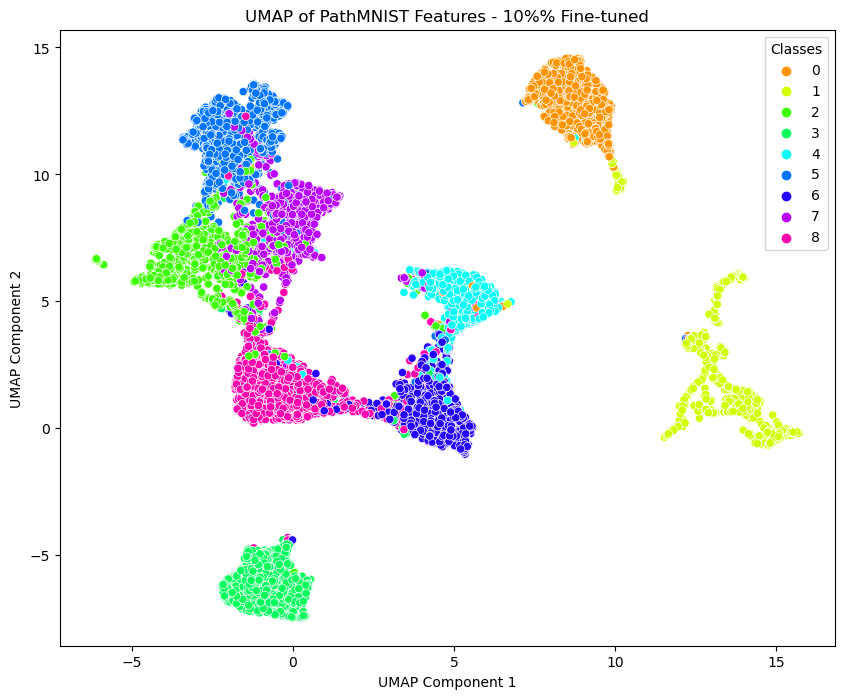

In [50]:
data = np.load('pathmnist_features_fine_tuned_100.npz')
features = data['features']
labels = data['labels']

umap_reducer = umap.UMAP(n_components=2)
features_2d = umap_reducer.fit_transform(features)

# make sure labels are 1D
labels = labels.squeeze()

df = pd.DataFrame({
    'UMAP1': features_2d[:, 0],
    'UMAP2': features_2d[:, 1],
    'Label': labels
})

# visualize the 2D features
plt.figure(figsize=(10, 8))
palette = sns.color_palette("hsv", len(set(labels)))
sns.scatterplot(data=df, x='UMAP1', y='UMAP2', hue='Label', legend='full', palette=palette)
plt.title('UMAP of PathMNIST Features - 10%% Fine-tuned')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Classes')
plt.show()
